# Installation

In [2]:
!pip install vit-pytorch


In [3]:
# vit_b16_minimal.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from vit_pytorch import ViT
from time import time

In [4]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


# Code


In [26]:
# ---------------------------
# 1. Data
# -----------------------------
transform = T.Compose([
    #T.Resize((128, 128)),  # smaller than 224 → faster
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = torchvision.datasets.CIFAR10("./data", train=True, download=True, transform=transform)
test_set  = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

Number of training images: 50000
Number of test images: 10000
Single image shape (C, H, W): torch.Size([3, 32, 32])
Label: 9


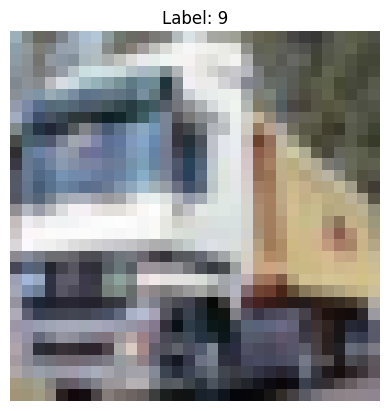

In [31]:
import matplotlib.pyplot as plt
import torchvision

# Print dataset sizes
print(f"Number of training images: {len(train_set)}")
print(f"Number of test images: {len(test_set)}")

# Get one sample
img, label = train_set[1]
print(f"Single image shape (C, H, W): {img.shape}")
print(f"Label: {label}")

# Show the image
plt.imshow(img.permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


In [32]:
# -----------------------------
# 2. Model: ViT-B/16
# -----------------------------
model = ViT(
    image_size=32,
    patch_size=4,     # patch size unchanged
    num_classes=10,
    dim=384,
    depth=6,
    heads=6,
    mlp_dim=1536,
    dropout=0.1,
    emb_dropout=0.1
).to(device)

In [33]:
# -----------------------------
# 3. Loss & optimizer
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scaler = torch.amp.GradScaler()  # mixed precision

In [34]:
# -----------------------------
# 4. Training loop
# -----------------------------
def train_one_epoch():
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device):
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()

    print(f"Train loss: {running_loss / len(train_loader):.4f}")

In [35]:
# -----------------------------
# 5. Evaluation
# -----------------------------
def evaluate():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Test Accuracy: {100*correct/total:.2f}%")


In [53]:
# -----------------------------
# 6. Run training + evaluation
# -----------------------------
for epoch in range(50):
    print(f"========= Epoch {epoch+1} ========")
    print("Training 1 epoch on CIFAR-10...")
    a = time()
    train_one_epoch()
    b = time()
    print(f"Training time one epoch {b-a} seconds")

In [55]:
print("Evaluating on test set...")
a = time()
evaluate()
b = time()
print(f"Evaluation time {b-a} seconds")

Evaluating on test set...
Test Accuracy: 70.49%
Evaluation time 5.21387791633606 seconds
